In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-04-11 18:12:15.365023: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 18:12:15.365076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 18:12:15.366524: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/stock-price/FPT.csv
/kaggle/input/stock-price/VIC.csv
/kaggle/input/stock-price/PNJ.csv
/kaggle/input/stock-price/MSN.csv


In [2]:
df = pd.read_csv("/kaggle/input/stock-price/FPT.csv")
print(df)

      Ticker         Date/Time   Open   High    Low  Close  Volume  \
0        FPT   12/25/2018 9:15  30.89  30.89  30.89  30.89   35410   
1        FPT   12/25/2018 9:16  30.81  30.81  30.81  30.81     190   
2        FPT   12/25/2018 9:17  30.74  30.81  30.74  30.74    1120   
3        FPT   12/25/2018 9:18  30.74  30.74  30.74  30.74    2120   
4        FPT   12/25/2018 9:19  30.74  30.74  30.74  30.74   22500   
...      ...               ...    ...    ...    ...    ...     ...   
97401    FPT  12/22/2020 14:24  58.20  58.20  58.20  58.20   27470   
97402    FPT  12/22/2020 14:25  58.20  58.20  58.20  58.20   14820   
97403    FPT  12/22/2020 14:26  58.20  58.20  58.20  58.20     500   
97404    FPT  12/22/2020 14:29  58.10  58.10  58.10  58.10    2500   
97405    FPT  12/22/2020 14:46  58.10  58.10  58.10  58.10   11170   

       Open Interest  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ... 

In [3]:
df.shape

(97406, 8)

In [4]:
df["Date/Time"] = pd.to_datetime(df["Date/Time"], format="%m/%d/%Y %H:%M", errors='coerce')
df.set_index('Date/Time',inplace=True)

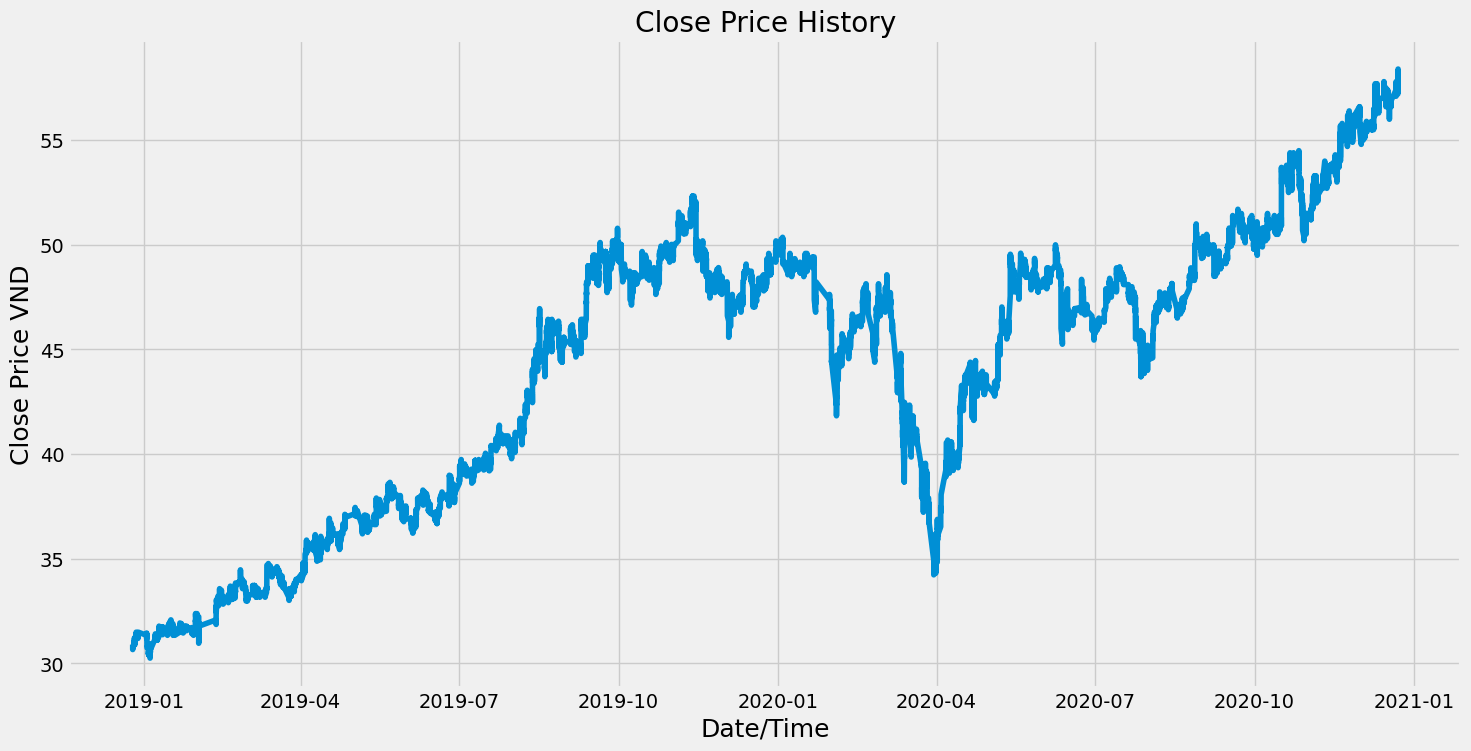

In [5]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date/Time', fontsize=18)
plt.ylabel('Close Price VND', fontsize=18)
plt.show()

In [6]:
#Creat a new dateframe with only the 'Close' column
data = df.filter(['Close'])
#Convert the dataframe to a numpy array
dataset = data.values
#Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * .8)

training_data_len 

77925

In [7]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.02273535],
       [0.01989343],
       [0.01740675],
       ...,
       [0.9928952 ],
       [0.98934281],
       [0.98934281]])

In [8]:
def data_loader(data, timesteps, features):
    x = []
    y = []
    
    for i in range(timesteps, len(data)):
        x.append(data[i - timesteps:i, :])
        y.append(data[i, :])
    
    x = np.array(x)
    y = np.array(y)
    
    return x,y

In [9]:
#Creat the training dataset
#Creat the scaled training dataset
train_data = scaled_data[0:training_data_len, :]

#Split the data into x_train and y_train datasets
x_train, y_train = data_loader(data=train_data, timesteps=60, features=1)

In [10]:
#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(77865, 60, 1)

**LSTM**

In [11]:
#Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

77865/77865 ━━━━━━━━━━━━━━━━━━━━ 476s 6ms/step - loss: 1.9741e-04


In [14]:
#Creat the testing dataset
test_data = scaled_data[training_data_len - 60: , :]

y_test = dataset[training_data_len: , :]

x_test, _ = data_loader(data=test_data, timesteps=60, features=1)


In [15]:
#Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [16]:
#Get the model predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

609/609 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [17]:
#Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.5435047060561788

/tmp/ipykernel_237/3710545049.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


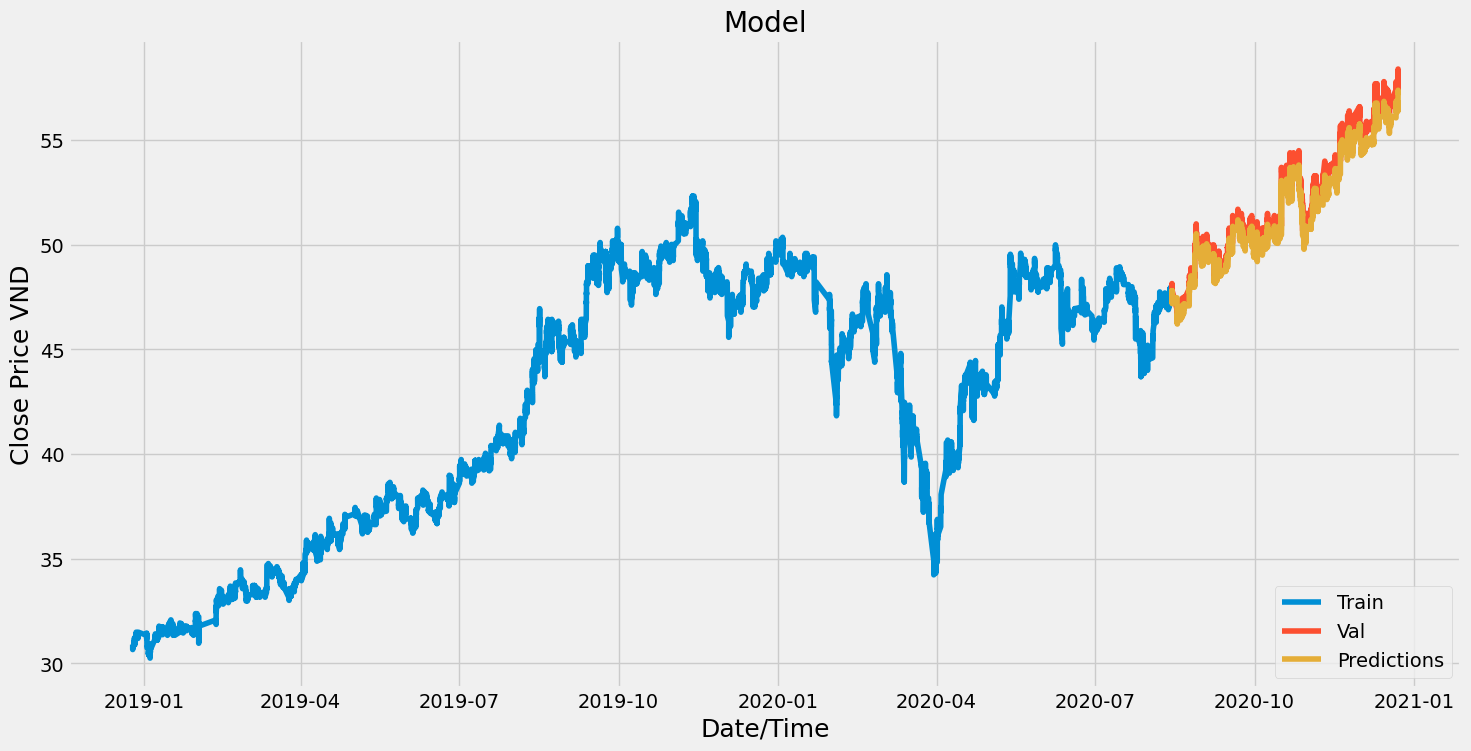

In [18]:
#Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date/Time', fontsize=18)
plt.ylabel('Close Price VND', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [19]:
#Show the valid and predicted prices
valid

,Close,Predictions
Date/Time,,
2020-08-14 09:34:00,48.10,47.745491
2020-08-14 09:35:00,48.10,47.756229
2020-08-14 09:36:00,48.10,47.757324
2020-08-14 09:37:00,48.15,47.755386
2020-08-14 09:38:00,48.15,47.795589
...,...,...
2020-12-22 14:24:00,58.20,57.231998
2020-12-22 14:25:00,58.20,57.235722
2020-12-22 14:26:00,58.20,57.236233


**Random Forest**

In [20]:
df

,Ticker,Open,High,Low,Close,Volume,Open Interest
Date/Time,,,,,,,
2018-12-25 09:15:00,FPT,30.89,30.89,30.89,30.89,35410,0
2018-12-25 09:16:00,FPT,30.81,30.81,30.81,30.81,190,0
2018-12-25 09:17:00,FPT,30.74,30.81,30.74,30.74,1120,0
2018-12-25 09:18:00,FPT,30.74,30.74,30.74,30.74,2120,0
2018-12-25 09:19:00,FPT,30.74,30.74,30.74,30.74,22500,0
...,...,...,...,...,...,...,...
2020-12-22 14:24:00,FPT,58.20,58.20,58.20,58.20,27470,0
2020-12-22 14:25:00,FPT,58.20,58.20,58.20,58.20,14820,0
2020-12-22 14:26:00,FPT,58.20,58.20,58.20,58.20,500,0


In [21]:
del df['Open Interest']

In [22]:
df['Next'] = df['Close'].shift(-1)

In [23]:
df

,Ticker,Open,High,Low,Close,Volume,Next
Date/Time,,,,,,,
2018-12-25 09:15:00,FPT,30.89,30.89,30.89,30.89,35410,30.81
2018-12-25 09:16:00,FPT,30.81,30.81,30.81,30.81,190,30.74
2018-12-25 09:17:00,FPT,30.74,30.81,30.74,30.74,1120,30.74
2018-12-25 09:18:00,FPT,30.74,30.74,30.74,30.74,2120,30.74
2018-12-25 09:19:00,FPT,30.74,30.74,30.74,30.74,22500,30.74
...,...,...,...,...,...,...,...
2020-12-22 14:24:00,FPT,58.20,58.20,58.20,58.20,27470,58.20
2020-12-22 14:25:00,FPT,58.20,58.20,58.20,58.20,14820,58.20
2020-12-22 14:26:00,FPT,58.20,58.20,58.20,58.20,500,58.10


In [24]:
#Price increase: 1, Price down: 0
df['Target'] = (df['Next'] > df['Close']).astype(int)

In [25]:
df

,Ticker,Open,High,Low,Close,Volume,Next,Target
Date/Time,,,,,,,,
2018-12-25 09:15:00,FPT,30.89,30.89,30.89,30.89,35410,30.81,0
2018-12-25 09:16:00,FPT,30.81,30.81,30.81,30.81,190,30.74,0
2018-12-25 09:17:00,FPT,30.74,30.81,30.74,30.74,1120,30.74,0
2018-12-25 09:18:00,FPT,30.74,30.74,30.74,30.74,2120,30.74,0
2018-12-25 09:19:00,FPT,30.74,30.74,30.74,30.74,22500,30.74,0
...,...,...,...,...,...,...,...,...
2020-12-22 14:24:00,FPT,58.20,58.20,58.20,58.20,27470,58.20,0
2020-12-22 14:25:00,FPT,58.20,58.20,58.20,58.20,14820,58.20,0
2020-12-22 14:26:00,FPT,58.20,58.20,58.20,58.20,500,58.10,0


In [26]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = df.iloc[:-training_data_len]
test = df.iloc[-training_data_len:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model_rf.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [27]:
from sklearn.metrics import precision_score

preds = model_rf.predict(test[predictors])

In [28]:
preds = pd.Series(preds, index=test.index)

In [29]:
precision_score(test["Target"], preds)

0.3654574986464537

In [30]:
combined = pd.concat([test["Target"], preds], axis=1)

In [31]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [32]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [34]:
predictions = backtest(df, model_rf, predictors)

In [35]:
predictions["Predictions"].value_counts()

Predictions
0    94709
1      197
Name: count, dtype: int64

In [36]:
precision_score(predictions["Target"], predictions["Predictions"])

0.3147208121827411

In [37]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
0    0.791425
1    0.208575
Name: count, dtype: float64

In [38]:
invalid_values = df.isnull().sum()
print(invalid_values)

Ticker    0
Open      0
High      0
Low       0
Close     0
Volume    0
Next      1
Target    0
dtype: int64


In [39]:
invalid_rows = df[df.isnull().any(axis=1)]
print(invalid_rows)


                    Ticker  Open  High   Low  Close  Volume  Next  Target
Date/Time                                                                
2020-12-22 14:46:00    FPT  58.1  58.1  58.1   58.1   11170   NaN       0


In [40]:
def create_features(df, horizons):
    # Lọc các cột số
    numeric_columns = df.select_dtypes(include=['number']).columns

    for horizon in horizons:

        rolling_averages = df[numeric_columns].rolling(horizon).mean()

        # Tỷ lệ đóng cửa
        ratio_column = f"Close_Ratio_{horizon}"
        df[ratio_column] = df["Close"] / rolling_averages["Close"]

        # Xu hướng
        trend_column = f"Trend_{horizon}"
        try:
          shifted_sum = df[numeric_columns].shift(1).rolling(horizon).sum()
          df[trend_column] = shifted_sum["Target"] 
        except KeyError:
          # Xử lý trường hợp không có cột "Target"
          df[trend_column] = np.nan
        except TypeError:  # Lỗi do cột không tương thích
          # In tên cột gây lỗi để kiểm tra
          print(f"Cột gây lỗi: {df.columns[shifted_sum.idxmin()]}")
          # Xử lý tùy theo loại lỗi (ví dụ, loại bỏ cột đó)
          df = df.drop(df.columns[shifted_sum.idxmin()], axis=1)

    return df


In [41]:
horizons = [2, 5, 60, 250, 1000]

df = create_features(df, horizons)

In [42]:
df = df.dropna(subset=df.columns[df.columns != "Next"])

In [43]:
df

,Ticker,Open,High,Low,Close,Volume,Next,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date/Time,,,,,,,,,,,,,,,,,,
2019-01-08 10:12:00,FPT,31.22,31.22,31.22,31.22,600,31.22,0,1.000481,1.0,1.000769,1.0,1.000459,12.0,1.004442,52.0,1.006572,203.0
2019-01-08 10:13:00,FPT,31.22,31.22,31.22,31.22,500,31.26,1,1.000000,1.0,1.000577,1.0,1.000443,12.0,1.004342,51.0,1.006559,203.0
2019-01-08 10:14:00,FPT,31.26,31.26,31.26,31.26,6300,31.26,0,1.000640,1.0,1.001410,2.0,1.001688,13.0,1.005542,51.0,1.007832,204.0
2019-01-08 10:15:00,FPT,31.26,31.26,31.26,31.26,30,31.30,1,1.000000,1.0,1.000961,2.0,1.001650,13.0,1.005455,51.0,1.007815,204.0
2019-01-08 10:16:00,FPT,31.30,31.30,31.30,31.30,1730,31.34,1,1.000639,1.0,1.001536,3.0,1.002873,14.0,1.006650,52.0,1.009086,205.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-22 14:24:00,FPT,58.20,58.20,58.20,58.20,27470,58.20,0,1.000000,1.0,1.001032,1.0,1.005529,18.0,1.011259,59.0,1.018462,220.0
2020-12-22 14:25:00,FPT,58.20,58.20,58.20,58.20,14820,58.20,0,1.000000,0.0,1.000688,1.0,1.005355,18.0,1.011196,59.0,1.018446,219.0
2020-12-22 14:26:00,FPT,58.20,58.20,58.20,58.20,500,58.10,0,1.000000,0.0,1.000344,1.0,1.005181,18.0,1.011133,59.0,1.018430,219.0


**Trend**
1. Trend_1000: Là giá trị thể hiện xu hướng của giá cổ phiếu FPT trong 1000 ngày qua.

2. Tính toán:
- Tính trung bình động của giá đóng cửa trong 1000 ngày trước đó.
- So sánh giá đóng cửa hiện tại với trung bình động 1000 ngày:
- Trend_1000 > 0: Giá đóng cửa cao hơn trung bình động, cho thấy xu hướng tăng.
- Trend_1000 = 0: Giá đóng cửa bằng trung bình động, cho thấy xu hướng trải.
- Trend_1000 < 0: Giá đóng cửa thấp hơn trung bình động, cho thấy xu hướng giảm.
3. Ý nghĩa:
- Giá trị Trend_1000 càng cao, xu hướng tăng càng mạnh.
- Giá trị Trend_1000 càng thấp, xu hướng giảm càng mạnh.

**Close_Ratio**
1. Close_Ratio_1000: Là tỷ lệ giữa giá đóng cửa hiện tại và trung bình động của giá đóng cửa trong 1000 ngày qua.

2. Công thức: Close_Ratio_1000 = Giá đóng cửa hiện tại / Trung bình động 1000 ngày

3. Ý nghĩa:
- Close_Ratio_1000 cho biết giá cổ phiếu hiện tại đắt hay rẻ so với giá trung bình trong 1000 ngày qua.
- Close_Ratio_1000 > 1: Giá cổ phiếu đắt hơn trung bình.
- Close_Ratio_1000 = 1: Giá cổ phiếu bằng trung bình.
- Close_Ratio_1000 < 1: Giá cổ phiếu rẻ hơn trung bình.